# JAX Basics 01
![image.png](https://github.com/jax-ml/jax/blob/main/images/jax_logo_250px.png?raw=true)

### Imports

In [40]:
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import lax
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

### Syntax

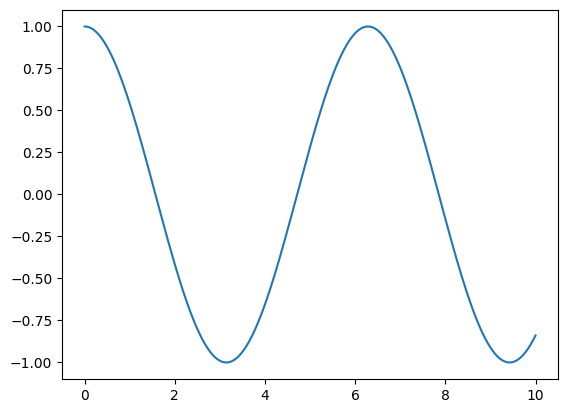

In [3]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

### Update Value

In [20]:
size = 10
index = 0
value = 100

x = jnp.arange(size)
print(x)

[0 1 2 3 4 5 6 7 8 9]


In [21]:
x[index] = value # Wrong
print(x)
print(y)

TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [22]:
y = x.at[index].set(value)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[100   1   2   3   4   5   6   7   8   9]


### Random

In [23]:
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10, ))
print(type(x), x)

<class 'jaxlib.xla_extension.ArrayImpl'> [ 1.6226422   2.0252647  -0.43359444 -0.07861735  0.1760909  -0.97208923
 -0.49529874  0.4943786   0.6643493  -0.9501635 ]


### Accelarator Comparison

In [24]:
size = 5000

x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()
%timeit np.dot(x_np, x_np.T)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()

x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()

4.94 s ± 744 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.17 s ± 468 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.67 s ± 459 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.01 s ± 606 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### ```jit()```


In [7]:
def visualize_fn(fn, l=-10, r=10, n=1000):
  x = np.linspace(l, r, num=n)
  y = fn(x)
  plt.plot(x, y)
  plt.show()

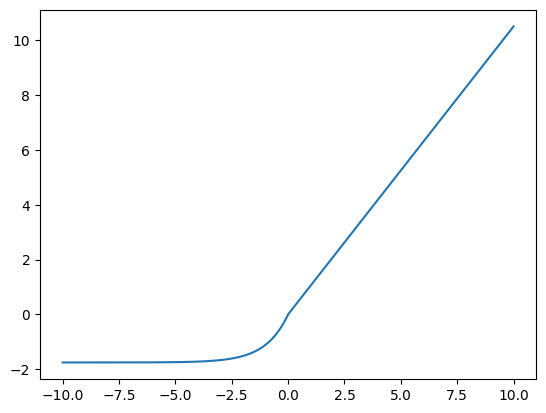

non-jit version:
4 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jit version:
1.27 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)

visualize_fn(selu)

data = random.normal(key, (1000000, ))

print('non-jit version:')
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

### ```grad()```

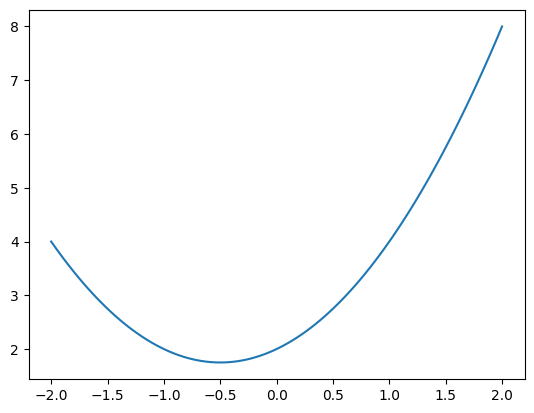

4.0 3.0 2.0 0.0


In [26]:
x = 1.

f = lambda x: x**2 + x + 2
visualize_fn(f, l=-2, r=2, n=100)

dfdx = grad(f)
d2fdx = grad(dfdx)
d3fdx = grad(d2fdx)

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))

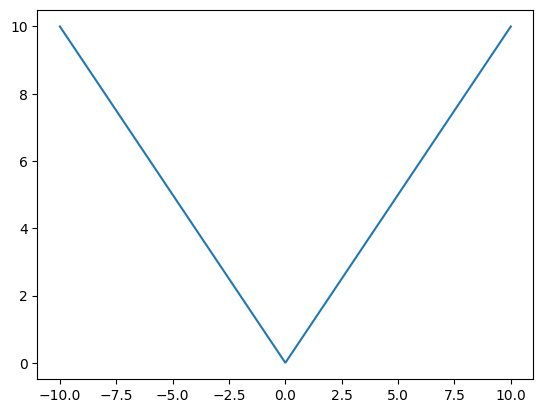

1 1
1.0


In [27]:
f = lambda x: abs(x)

visualize_fn(f)

print(f(-1), f(1))
dfdx = grad(f)
print(dfdx(0.))

### ```vmap()```

In [28]:
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(x):
  return jnp.dot(W, x)

In [29]:
def naively_batched_apply_matrix(batched_x):
  return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
1.38 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
def batched_apply_matrix(batched_x):
  return jnp.dot(batched_x, W.T)

print("Manually batched")
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
171 µs ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
@jit
def batched_apply_matrix(batched_x):
  return jnp.dot(batched_x, W.T)

print("Manually batched")
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
42.2 µs ± 688 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [32]:
def vmap_batched_apply_matrix(batched_x):
  return vmap(apply_matrix)(batched_x)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
852 µs ± 91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
@jit
def vmap_batched_apply_matrix(batched_x):
  return vmap(apply_matrix)(batched_x)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
75.6 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### jitted functions are faster


In [34]:
def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)

norm_compiled = jit(norm)

X = random.normal(key, (10000, 100), dtype=jnp.float32)

assert np.allclose(norm(X), norm_compiled(X), atol=1E-6)

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

4.37 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.01 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
def get_neg(x):
  return x[x < 0]

x = random.normal(key, (10,), dtype=jnp.float32)
print(get_neg(x))

[-0.43359444 -0.07861735 -0.97208923 -0.49529874 -0.9501635 ]


In [37]:
print(jit(get_neg)(x)) # Wrong

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

### Side Effects, like print() is not complied

In [38]:
@jit
def f(x, y):
  print("Running f():")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print("Second function call:")
print(f(x2, y2))


Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace>
[5.100988  1.2151402 1.9297588]
Second function call:
[5.474458  1.0589452 2.647187 ]


In [41]:
def f(x, y):
  return jnp.dot(x + 1, y + 1)

print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


### Pure Function

In [48]:
g = 0

def impure_uses_global(x):
  return x + g

print("Frist call", jit(impure_uses_global)(4.))

g = 10

print("Second call", jit(impure_uses_global)(5.))
print("Third call, different type", jit(impure_uses_global)(jnp.array([4.])))

Frist call 4.0
Second call 5.0
Third call, different type [14.]


In [49]:
def pure_uses_internal_state(x):
  state = dict(even=0, odd=0)
  for i in range(10):
    state["even" if i % 2 == 0 else "odd"] += x

  return state['even'] + state['odd']

print(jit(pure_uses_internal_state)(5.))

50.0


### Out of Bound Behavior

In [55]:
print(jnp.arange(10).at[11].add(23)) # skipped
print(jnp.arange(10)[9])
print(jnp.arange(10)[10])
print(jnp.arange(10)[11])
print(jnp.arange(10)[110])       # Undefined behavior

[0 1 2 3 4 5 6 7 8 9]
9
9
9
9
